In [38]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [39]:
df = pd.read_excel('Calibrated_Drone_data.xlsx')
df2 = pd.read_csv('Updated_Drone.csv')


In [40]:
df

,Time (s),Mass (kg),Force (kN)
0,0.001774,1199.551971,15.496357
1,0.001908,1200.271888,15.598556
2,0.001530,1200.670244,15.505701
3,0.001532,1201.062745,15.551564
4,0.000745,1201.136454,16.555157
...,...,...,...
1297,0.000572,1498.711461,288.966634
1298,0.000688,1499.437782,288.156407
1299,0.000702,1499.093148,284.353904
1300,0.000567,1500.018053,288.142237


In [41]:
# Scale the 'Maximum Principal Elastic Strain' column by 10^10
df['Time (s)'] = df['Time (s)'] * 1000000

# Optionally, check the updated values
print(df.head())

      Time (s)    Mass (kg)  Force (kN)
0  1773.951086  1199.551971   15.496357
1  1908.324679  1200.271888   15.598556
2  1529.652377  1200.670244   15.505701
3  1531.693419  1201.062745   15.551564
4   744.600857  1201.136454   16.555157


In [42]:
df2

,Time (s),Mass (kg),Force (kN)
0,0.001799,1200.000000,15.596330
1,0.001818,1200.230592,15.596330
2,0.001483,1200.461184,15.596330
3,0.001512,1200.691776,15.596330
4,0.000813,1200.922367,16.513761
...,...,...,...
1297,0.000651,1499.077633,288.990826
1298,0.000660,1499.308224,288.073394
1299,0.000660,1499.538816,284.403670
1300,0.000660,1499.769408,288.073394


In [43]:
# Scale the 'Maximum Principal Elastic Strain' column by 10^10
df2['Time (s)'] = df2['Time (s)'] * 1000000

# Optionally, check the updated values
print(df.head())

      Time (s)    Mass (kg)  Force (kN)
0  1773.951086  1199.551971   15.496357
1  1908.324679  1200.271888   15.598556
2  1529.652377  1200.670244   15.505701
3  1531.693419  1201.062745   15.551564
4   744.600857  1201.136454   16.555157


In [44]:
# Pearson Correlation
def calculate_pearson_correlation(data1, data2):
    corr, _ = pearsonr(data1['Force (kN)'], data2['Force (kN)'])
    return corr

# Root Mean Squared Error (RMSE)
def calculate_rmse(data1, data2):
    rmse = np.sqrt(mean_squared_error(data1['Force (kN)'], data2['Force (kN)']))
    return rmse

# Run calculations
pearson_correlation = calculate_pearson_correlation(df, df2)
rmse_values = calculate_rmse(df, df2)

# Output results
print("Pearson Correlation:", pearson_correlation)
print("RMSE Values:", rmse_values)

Pearson Correlation: 0.9999997967718453
RMSE Values: 0.05762338609500627


In [45]:
from skopt.space import Real, Integer
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from scipy.stats import qmc  

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [46]:
# Define the hyperparameter space
hyp_space  = [
    Integer(3, 10, name='num_layers'), # Num of layers in the network (depth)
    Integer(50, 200, name='num_units'), # Num of neurons in each hidden layer (width)
    Real(0.00001, 0.1, prior='log-uniform', name='learning_rate'), # Steps size at each iteration 
    Real(0.0, 0.5, name='dropout_rate'), # Probability of droping out a neuron
    Integer(20, 150, name='batch_size'), # Num of samples per batch
    Integer(50, 200, name='epochs') # Num of epochs (iterations over the entire dataset) during training
]

# Defining the Neural Network Model
def NN_model(num_layers, num_units, learning_rate, dropout_rate):
    inputs = Input(shape=(2,))
    x = Dense(num_units, activation='relu', kernel_regularizer='l2')(inputs)
    for _ in range(num_layers - 1):
        x = Dense(num_units, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='linear')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function for MC Dropout predictions
def mc_dropout_predictions(model, X, num_samples=50):
    predictions = np.zeros((num_samples, X.shape[0]))
    for i in range(num_samples):
        predictions[i, :] = model(X, training=True).numpy().flatten()
    prediction_mean = predictions.mean(axis=0)
    prediction_std = predictions.std(axis=0)
    return prediction_mean, prediction_std

In [47]:
# Define the objective function to minimize
@use_named_args(hyp_space)
def objective(**params):
    num_layers = params['num_layers']
    num_units = params['num_units']
    learning_rate = params['learning_rate']
    dropout_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    model = NN_model(num_layers, num_units, learning_rate, dropout_rate)

    # Define K-fold cross-validation
    kfold = KFold(n_splits=3, shuffle=True, random_state=0)
    scores = []

    # Perform cross-validation
    for train_idx, val_idx in kfold.split(df2[['Mass (kg)','Time (s)']]):
        X_train, X_val = df2[['Mass (kg)','Time (s)']].iloc[train_idx], df2[['Mass (kg)','Time (s)']].iloc[val_idx]
        y_train, y_val = df2[['Force (kN)']].iloc[train_idx], df2[['Force (kN)']].iloc[val_idx]

        # Standardize the features
        scaler_x = StandardScaler().fit(X_train)
        X_train_scaled = scaler_x.transform(X_train)
        X_val_scaled = scaler_x.transform(X_val)

        # Train the model
        # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train_scaled, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_scaled, y_val))

        # Evaluate the model
        score = model.evaluate(X_val_scaled, y_val, verbose=0)
        scores.append(score)
    
    return np.mean(scores)

# Perform Bayesian optimization
result = gp_minimize(objective, hyp_space, n_calls=30, random_state=0, acq_func='EI')

# Output best hyperparameters from BayesOpt
print("Best hyperparameters:")
print("num_layers:", result.x[0])
print("num_units:", result.x[1])
print("learning_rate:", result.x[2])
print("dropout_rate:", result.x[3])
print("batch_size:", result.x[4])
print("epochs:", result.x[5])

# Train the model with the best hyperparameters
best_model = NN_model(
    num_layers=result.x[0],
    num_units=result.x[1],
    learning_rate=result.x[2],
    dropout_rate=result.x[3],
)

Best hyperparameters:
num_layers: 10
num_units: 50
learning_rate: 0.00028464578938388734
dropout_rate: 0.0
batch_size: 20
epochs: 91


In [53]:
best_model = NN_model(
    num_layers=10,
    num_units=50,
    learning_rate=0.002,
    dropout_rate=0,
)

In [56]:
from sklearn.model_selection import train_test_split

train_X = df[['Mass (kg)','Time (s)']].to_numpy()
train_y = df['Force (kN)'].to_numpy()

# Standardize the initial dataset
scaler_x = StandardScaler().fit(train_X)
X_scaled = scaler_x.transform(train_X)

Epoch 1/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 539.3687 
Epoch 2/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 1897.3855
Epoch 3/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 364.0009
Epoch 4/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 386.9506
Epoch 5/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 1372.0729
Epoch 6/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 367.7792
Epoch 7/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 382.2980
Epoch 8/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 366.4097
Epoch 9/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 385.6348
Epoch 10/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 467.7013
Epoch 11/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 444.2727
Epoch 12/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 433.0352
Epoch 13/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 360.1602
Epoch 14/91
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 347.8173
Epoch 15/91
66/66 ━━━━━━━━━

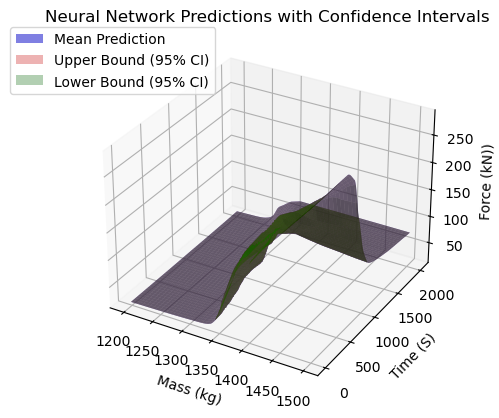

In [57]:
# Train the best model on training set
best_model.fit(X_scaled, train_y, epochs=91, batch_size=20, verbose=1)

# Produce Meshgrid of input space
x1_range = np.linspace(1198, 1501, 100)
x2_range  = np.linspace(1, 2030, 100)

x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
x_grid = np.c_[x1_grid.ravel(), x2_grid.ravel()]

x_grid = scaler_x.transform(x_grid)

# Perform MC Dropout predictions for entire meshgrid
pred_mean, pred_std = mc_dropout_predictions(best_model, x_grid)

# Define range for inputs
bounds = np.array([[30, 120], [5, 800]])

# Identify top 10 points with highest uncertainty
num_new_points = 10

sampler = qmc.LatinHypercube(d=2)  # LHS in a 1D space
lhs_sample = sampler.random(n=1000)
lhs_points = qmc.scale(lhs_sample, bounds[:, 0], bounds[:, 1])

lhs_points_scaled = scaler_x.transform(lhs_points)

lhs_mean, lhs_std = mc_dropout_predictions(best_model, lhs_points_scaled)
percentile_threshold = 10 
threshold_value = np.percentile(lhs_mean, percentile_threshold)

# Filter points above the threshold
points_above_threshold = lhs_points[lhs_mean <= threshold_value]

num_new_points = 10
if len(points_above_threshold) > num_new_points:
    selected_indices = np.random.choice(len(points_above_threshold), num_new_points, replace=False)
    selected_points = points_above_threshold[selected_indices]
else:
    selected_points = points_above_threshold

new_points_df = pd.DataFrame(selected_points, columns=['x','y'])

# Ploting mean predictions and confidence intervals
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Reshaping predictions back to grid shape
pred_mean_grid = pred_mean.reshape(x1_grid.shape)
pred_upper_grid = (pred_mean + (1.96 * pred_std)).reshape(x1_grid.shape)
pred_lower_grid = (pred_mean - (1.96 * pred_std)).reshape(x1_grid.shape)

mean_surface = ax.plot_surface(x1_grid, x2_grid, pred_mean_grid, color='blue', alpha=0.5, label='Mean Prediction')
upper_surface = ax.plot_surface(x1_grid, x2_grid, pred_upper_grid, color='red', alpha=0.3, label='Upper Bound (95% CI)')
lower_surface = ax.plot_surface(x1_grid, x2_grid, pred_lower_grid, color='green', alpha=0.3, label='Lower Bound (95% CI)')

# Getting mean of new points for visualization
new_x = new_points_df[['x', 'y']].to_numpy()
new_x = scaler_x.transform(new_x)
new_mean, new_std = mc_dropout_predictions(best_model, new_x)

# Plot Labels
ax.set_title('Neural Network Predictions with Confidence Intervals')
ax.set_xlabel('Mass (kg)')
ax.set_ylabel('Time (S)')
ax.set_zlabel('Force (kN))')

# Legend
legend_elements = [mean_surface, upper_surface, lower_surface]
fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()